In [1]:
import pickle
import gzip

import utils

import loompy
import pandas as pd
import numpy as np
import scipy.sparse as sp

import matplotlib.pyplot as plt
%matplotlib inline

/home/ppolicar/nfs/miniconda/envs/tsne/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ppolicar/nfs/miniconda/envs/tsne/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
%%time
data = pd.read_table("data/GSE63472_P14Retina_merged_digital_expression.txt.gz", index_col=0)
data.head()

CPU times: user 10min 4s, sys: 11.2 s, total: 10min 15s
Wall time: 10min 15s


In [3]:
%%time
cluster_ids = pd.read_table("data/retina_clusteridentities.txt", header=None, index_col=0, squeeze=True)

CPU times: user 48 ms, sys: 8 ms, total: 56 ms
Wall time: 58.3 ms


In [4]:
cluster_ids.head()

0
r1_GGCCGCAGTCCG     2
r1_CTTGTGCGGGAA     2
r1_GCGCAACTGCTC     2
r1_GATTGGGAGGCA     2
r1_GTGCCGCCTCTC    25
Name: 1, dtype: int64

In [5]:
# Reorder
cluster_ids = cluster_ids[data.columns.values]

In [6]:
data.shape

(24658, 49300)

In [7]:
# Only use cells where metadata is available
ind = data.columns.isin(cluster_ids.index)
data = data.loc[:, ind]

In [8]:
data.shape, cluster_ids.shape

((24658, 49300), (49300,))

In [9]:
mask = ~cluster_ids.isna()
data = data.loc[:, mask.values]
cluster_ids = cluster_ids[mask]

In [10]:
assert not cluster_ids.isna().any(), "Did not properly remove cells with NaN label"

In [11]:
data.shape, cluster_ids.shape

((24658, 44808), (44808,))

In [12]:
%%time
counts = sp.csr_matrix(data.values)
counts

CPU times: user 12.4 s, sys: 0 ns, total: 12.4 s
Wall time: 12.4 s


In [13]:
%%time
cpm_counts = utils.calculate_cpm(counts, axis=0)
log_counts = utils.log_normalize(cpm_counts)

CPU times: user 2.34 s, sys: 52 ms, total: 2.39 s
Wall time: 1.12 s


In [14]:
cell_types = cluster_ids.astype(object)

cell_types.loc[cell_types == 1] = "Horizontal cells"
cell_types.loc[cell_types == 2] = "Retinal ganglion cells"
cell_types.loc[cell_types.isin(range(3, 24))] = "Amacrine cells"
cell_types.loc[cell_types == 24] = "Rods"
cell_types.loc[cell_types == 25] = "Cones"
cell_types.loc[cell_types.isin(range(26, 34))] = "Bipolar cells"
cell_types.loc[cell_types == 34] = "Muller glia"
cell_types.loc[cell_types == 35] = "Astrocytes"
cell_types.loc[cell_types == 36] = "Fibroblasts"
cell_types.loc[cell_types == 37] = "Vascular endothelium"
cell_types.loc[cell_types == 38] = "Pericytes"
cell_types.loc[cell_types == 39] = "Microglia"

cell_types.value_counts()

Rods                      29400
Bipolar cells              6285
Amacrine cells             4426
Cones                      1868
Muller glia                1624
Retinal ganglion cells      432
Horizontal cells            252
Vascular endothelium        252
Fibroblasts                  85
Microglia                    67
Pericytes                    63
Astrocytes                   54
Name: 1, dtype: int64

## Preprocess data set

### Dropout based feature selection

Chosen offset: 0.19
CPU times: user 3.87 s, sys: 148 ms, total: 4.02 s
Wall time: 1.13 s


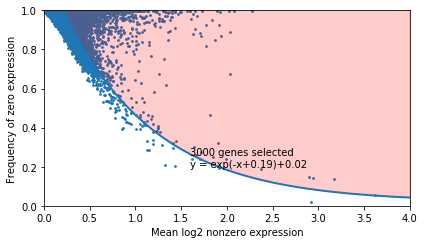

In [15]:
%time gene_mask = utils.select_genes(counts.T, n=3000, threshold=0)

In [16]:
x = log_counts.T[:, gene_mask].toarray()
x.shape

(44808, 3000)

### Standardize data

In [17]:
x -= x.mean(axis=0)
x /= x.std(axis=0)

### PCA preprocessing

In [18]:
%%time
U, S, V = np.linalg.svd(x, full_matrices=False)
U[:, np.sum(V, axis=1) < 0] *= -1
x_reduced = np.dot(U, np.diag(S))
x_reduced = x_reduced[:, np.argsort(S)[::-1]][:, :50]

CPU times: user 2min 2s, sys: 1.76 s, total: 2min 3s
Wall time: 23.1 s


In [19]:
x_reduced.shape

(44808, 50)

In [20]:
cell_types.shape

(44808,)

## Write data

In [21]:
data_dict = {"pca_50": x_reduced,
             "CellType1": cell_types.values.astype(str),
             "CellType2": cluster_ids.values.astype(str)}

In [22]:
%%time
with gzip.open("data/macosko_2015.pkl.gz", "wb") as f:
    pickle.dump(data_dict, f)

CPU times: user 732 ms, sys: 16 ms, total: 748 ms
Wall time: 755 ms
